Double Machine Learningを用いたSteamゲーム市場における因果推論：Chen (2025) 手法の適用と頑健性の検証

In [93]:
import kagglehub
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS, RandomEffects
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from stargazer.stargazer import Stargazer
from scipy.stats import chi2

pd.options.display.float_format = '{:.2f}'.format

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

Neyman_Orthogonality_Proof.md
    - DML_Algorithm_Steps.md         <-- スクラッチ実装の設計図.  
    - CATE_vs_ATE.md.
末石本（ATEとLATE）.  
GMMの直行条件→ネイマン直交→その他学習者（SとかTとか）→DML.  

ロードマップ:4章（行列表記と漸近理論）→3章（ATEとLATE）→5章（GMM）→論文（導出・理解(CATE・ネイマン直交・SとかTラーナー・DML)）→論文（実装）.  
5章（GMM）→論文（導出・理解(CATE・ネイマン直交・SとかTラーナー・DML)）→論文（実装）

Lasso

フリッシュ＝ウォー＝ロベル（FWL）定理

In [29]:
path = kagglehub.dataset_download("fronkongames/steam-games-dataset")

print("保存先パス:", path)

csv_path = os.path.join(path, "games.csv")

df = pd.read_csv(csv_path, index_col=False, quotechar='"')
df.head()

保存先パス: /Users/kavuk/.cache/kagglehub/datasets/fronkongames/steam-games-dataset/versions/31


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,2539430,Black Dragon Mage Playtest,"Aug 1, 2023",0 - 0,0,0,0.00,0,0,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,https://shared.akamai.steamstatic.com/store_it...
1,496350,Supipara - Chapter 1 Spring Has Come!,"Jul 29, 2016",0 - 20000,0,0,5.24,65,0,"Springtime, April: when the cherry trees come ...",...,8,0,8,0,minori,MangaGamer,"Single-player,Steam Trading Cards,Steam Cloud,...",Adventure,"Adventure,Visual Novel,Anime,Cute",https://shared.akamai.steamstatic.com/store_it...
2,1034400,Mystery Solitaire The Black Raven,"May 6, 2019",0 - 20000,0,0,4.99,0,0,"Immerse yourself in the most beloved, mystical...",...,0,0,0,0,Somer Games,8floor,"Single-player,Family Sharing",Casual,"Casual,Card Game,Solitaire,Puzzle,Hidden Objec...",https://shared.akamai.steamstatic.com/store_it...
3,3292190,버튜버 파라노이아 - Vtuber Paranoia,"Oct 31, 2024",0 - 20000,1,0,8.99,0,1,"synopsis 'Hello, I'm Hiyoro, a new YouTuber!' ...",...,0,0,0,0,유진게임즈,유진게임즈,"Single-player,Steam Achievements,Family Sharing","Casual,Indie,Simulation",NaN,https://shared.akamai.steamstatic.com/store_it...
4,3631080,Maze Quest VR,"Apr 24, 2025",0 - 20000,0,0,4.99,0,0,Its not just a Maze; its a Quest! Enter the ca...,...,0,0,0,0,Reality Expanded LLC,Reality Expanded LLC,"Single-player,VR Only,Steam Leaderboards,Famil...","Action,Early Access",NaN,https://shared.akamai.steamstatic.com/store_it...


In [30]:
# 1. 'DiscountDLC count' を 2つに分ける（もし中身が混ざっているなら）
# もし単に名前が間違っているだけなら、rename でOK
df = df.rename(columns={'DiscountDLC count': 'Discount'})

# 2. 特徴量として使わなさそうな「画像」や「URL」を削る（DMLのSELECT的な操作）
drop_cols = ['Header image', 'Website', 'Support url', 'Support email', 'Metacritic url']
df_clean = df.drop(columns=drop_cols)

# 3. 欠損値（NaN）の処理
df_clean = df_clean.dropna(subset=['Price', 'Peak CCU'])

# スペースをアンダースコアに置換
df.columns = [c.replace(' ', '_') for c in df.columns]

In [74]:
df['nega_notes_ratio'] = df['Negative'] / (df['Notes'] + 1)
df['log_ccu'] = np.log(df['Peak_CCU'] + 1)
df['log_negative'] = np.log(df['Negative'] + 1)
df['log_notes'] = np.log(df['Notes'] + 1)
df['log_median_playtime'] = np.log1p(df['Median_playtime_forever'])

In [37]:
print(df.columns)

Index(['AppID', 'Name', 'Release_date', 'Estimated_owners', 'Peak_CCU',
       'Required_age', 'Price', 'Discount', 'About_the_game',
       'Supported_languages', 'Full_audio_languages', 'Reviews',
       'Header_image', 'Website', 'Support_url', 'Support_email', 'Windows',
       'Mac', 'Linux', 'Metacritic_score', 'Metacritic_url', 'User_score',
       'Positive', 'Negative', 'Score_rank', 'Achievements', 'Recommendations',
       'Notes', 'Average_playtime_forever', 'Average_playtime_two_weeks',
       'Median_playtime_forever', 'Median_playtime_two_weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies',
       'log_ccu'],
      dtype='object')


In [42]:
df.sample(n=15)

,AppID,Name,Release_date,Estimated_owners,Peak_CCU,Required_age,Price,Discount,About_the_game,Supported_languages,...,Median_playtime_forever,Median_playtime_two_weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies,log_ccu
103733,1742730,Greek Tragedy,"Oct 30, 2025",0 - 20000,0,0,15.99,0,0,"Welcome to Southern Michigan University, your ...",...,0,0,0,"Cute Spooks,Prairieville Games",Pineapple Works,"Single-player,Steam Achievements,Full controll...","Action,Adventure,Indie",NaN,https://shared.akamai.steamstatic.com/store_it...,0.000000
120279,3897140,Sunday League Manager: Horse and Spoon,"Aug 29, 2025",0 - 20000,0,0,4.79,20,0,Sunday League Manager Welcome to the Beautiful...,...,0,0,0,christianosway,christianosway,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Simulation,Sports,Strategy",NaN,https://shared.akamai.steamstatic.com/store_it...,0.000000
63759,2443820,52 / 0 = ∞,"Jul 3, 2025",0 - 20000,0,0,0.00,0,0,52 / 0 = ∞. What does it mean? I do not promis...,...,0,0,0,HeFake,HeFake,"Single-player,Chat Text-to-speech,Mouse Only O...","Adventure,Indie",NaN,https://shared.akamai.steamstatic.com/store_it...,0.000000
7045,1346890,Motoride Rollercoaster VR,"Jul 22, 2020",0 - 20000,0,0,1.99,0,0,Motoride Rollercoaster VR will take you to a j...,...,0,7,0,Split Light Studio,Split Light Studio,"Single-player,Tracked Controller Support,VR On...","Adventure,Casual,Indie,Racing,Simulation","Simulation,Automobile Sim,Singleplayer,Adventu...",https://shared.akamai.steamstatic.com/store_it...,0.000000
40443,671390,Metropolis: Lux Obscura,"Oct 11, 2017",0 - 20000,0,0,4.39,0,2,Metropolis Lux Obscura is a unique game with a...,...,0,0,0,Ktulhu Solutions,Ktulhu Solutions,"Single-player,Steam Achievements,Full controll...","Casual,Indie","Sexual Content,Nudity,Match 3,Indie,Casual,Com...",https://shared.akamai.steamstatic.com/store_it...,0.000000
47622,3664300,디시인사이드 중붕이의 모험2 (Jungbung's Adventure 2),"May 7, 2025",0 - 0,0,0,0.00,0,0,This game supports English subtitles. This is ...,...,0,0,0,SEO SOFT,SEO SOFT,Full controller support,"RPG,Free To Play,Game Development",NaN,https://shared.akamai.steamstatic.com/store_it...,0.000000
42511,1509090,Seek Girl Ⅷ,"Apr 30, 2021",50000 - 100000,0,0,0.99,0,0,Join the Discord We have now opened the discor...,...,0,25,0,DSGame,DSGame,"Single-player,Family Sharing","Casual,Indie","Mature,Sexual Content,NSFW,Indie,Casual,Single...",https://shared.akamai.steamstatic.com/store_it...,0.000000
241,1555470,Zombie Blender,"Dec 23, 2021",0 - 20000,0,0,2.49,0,0,Zombie Blender is a retro indie 2D shooter whe...,...,0,0,0,Montenegro Gaming,Montenegro Gaming,"Single-player,Family Sharing",NaN,NaN,https://shared.akamai.steamstatic.com/store_it...,0.000000
29539,358360,Raptor: Call of the Shadows (1994 Classic Edit...,"May 5, 2014",50000 - 100000,0,0,0.84,83,0,Raptor set a new standard for PC shooters. Its...,...,0,70,0,Cygnus Studios,Apogee Entertainment,"Single-player,Partial Controller Support,Famil...",Action,"Action,Shoot 'Em Up,Classic,2D,Old School,1990...",https://shared.akamai.steamstatic.com/store_it...,0.000000
18227,2491380,Marble Magicks,"Aug 10, 2023",0 - 20000,0,0,0.49,0,0,In this Game your goal is to place 3 marbles o...,...,0,0,0,Epidra2077,Epidra2077,"Single-player,Multi-player,PvP,Shared/Split Sc...",Casual,"Score Attack,Casual,Solitaire,Match 3,Arcade,2...",https://shared.akamai.steamstatic.com/store_it...,0.000000


In [39]:
df.describe()

,AppID,Peak_CCU,Required_age,Price,Discount,About_the_game,Metacritic_url,Positive,Negative,Score_rank,Achievements,Recommendations,Notes,Average_playtime_two_weeks,Median_playtime_forever,Median_playtime_two_weeks,Developers,log_ccu
count,1.226110e+05,1.226110e+05,122611.000000,122611.000000,122611.000000,122611.000000,122611.000000,122611.000000,1.226110e+05,1.226110e+05,40.000000,122611.000000,1.226110e+05,1.226110e+05,122611.000000,1.226110e+05,122611.000000,122611.000000
mean,1.985386e+06,5.459332e+01,0.167611,4.765091,18.353663,0.545856,2.564941,0.024549,1.044986e+03,1.691974e+02,99.175000,18.087015,9.618250e+02,2.080232e+02,13.789268,1.735705e+02,14.722170,0.333299
std,1.087595e+06,3.729452e+03,1.653591,12.531030,28.858970,14.516026,13.660559,1.394901,2.809173e+04,5.374645e+03,0.675107,141.493879,2.187880e+04,1.121768e+04,270.378053,1.120254e+04,294.509615,1.039445
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,98.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.063175e+06,0.000000e+00,0.000000,0.550000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,99.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
50%,1.907380e+06,0.000000e+00,0.000000,2.240000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,1.000000e+00,99.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
75%,2.869560e+06,0.000000e+00,0.000000,5.240000,40.000000,0.000000,0.000000,0.000000,3.700000e+01,1.000000e+01,100.000000,19.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
max,4.264350e+06,1.013936e+06,21.000000,999.980000,100.000000,3703.000000,97.000000,100.000000,7.642084e+06,1.173003e+06,100.000000,9821.000000,4.830455e+06,3.429544e+06,20088.000000,3.429544e+06,20088.000000,13.829351


In [10]:
# カラムごとの欠損値の個数を確認
print(df.isnull().sum())

# カラムごとの欠損率（%）を確認
# print(df.isnull().mean() * 100)

AppID                              0
Name                               1
Release_date                       0
Estimated_owners                   0
Peak_CCU                           0
Required_age                       0
Price                              0
Discount                           0
About_the_game                     0
Supported_languages             8449
Full_audio_languages               0
Reviews                            0
Header_image                  110541
Website                           81
Support_url                    72935
Support_email                  68469
Windows                        22263
Mac                                0
Linux                              0
Metacritic_score                   0
Metacritic_url                     0
User_score                    118355
Positive                           0
Negative                           0
Score_rank                         0
Achievements                  122571
Recommendations                    0
N

In [78]:
#ヘックマンの2段階推定もどき、
df_active = df[df['Peak_CCU'] > 0].copy()

df_100 = df[df['Peak_CCU'] >= 100].copy()
df_100.describe()

# 1. 1000以上で絞る
df_1000 = df[df['Peak_CCU'] >= 1000].copy()
df_1000.describe()

,AppID,Peak_CCU,Required_age,Price,Discount,About_the_game,Metacritic_url,Positive,Negative,Score_rank,...,Average_playtime_two_weeks,Median_playtime_forever,Median_playtime_two_weeks,Developers,log_ccu,log_negative,log_notes,posi_nega_ratio,log_median_playtime,nega_notes_ratio
count,491.00,491.00,491.00,491.00,491.00,491.00,491.00,491.00,491.00,491.00,...,491.00,491.00,491.00,491.00,491.00,491.00,491.00,491.00,491.00,491.00
mean,1198654.93,12355.57,3.40,12.36,38.06,8.55,35.84,0.00,151374.59,23079.70,...,5571.86,750.42,1518.73,681.75,8.26,10.63,9.73,0.00,5.83,2290.60
std,886939.88,57685.74,6.74,13.61,32.62,21.08,41.55,0.00,412570.04,80932.88,...,8068.68,1299.96,3209.61,1501.56,1.16,2.06,3.36,0.00,1.57,16235.41
min,10.00,1001.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,6.91,0.00,0.00,0.00,0.00,0.00
25%,427465.00,1549.00,0.00,2.49,0.00,0.00,0.00,0.00,18610.00,2369.50,...,1709.50,220.50,466.00,135.00,7.35,9.83,9.01,0.00,5.40,0.87
50%,1086940.00,2777.00,0.00,7.99,34.00,2.00,0.00,0.00,55844.00,6058.00,...,2927.00,401.00,860.00,281.00,7.93,10.93,10.71,0.00,6.00,1.01
75%,1790885.00,7078.50,0.00,17.99,70.00,8.00,83.00,0.00,140318.50,18859.50,...,6042.00,750.00,1501.00,547.00,8.86,11.85,11.74,0.00,6.62,1.25
max,3454590.00,1013936.00,18.00,69.99,95.00,252.00,96.00,0.00,7642084.00,1173003.00,...,84477.00,13370.00,47987.00,13370.00,13.83,15.85,15.39,0.00,9.50,228817.00


In [ ]:
top_corr_cols = df.corr(numeric_only=True)['Peak_CCU'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
# plt.title('すべてのデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_active.corr(numeric_only=True)['Peak_CCU'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_active[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
# plt.title('Peak_CCU > 0 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_100.corr(numeric_only=True)['Peak_CCU'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_100[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
# plt.title('Peak_CCU > 0 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_1000.corr(numeric_only=True)['Peak_CCU'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_1000[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
# plt.title('Peak_CCU > 0 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

KeyError: 'Peak_CCU'

In [51]:
zero_count = (df['Peak_CCU'] == 0).sum()
print(f"同時接続ゼロのゲーム数: {zero_count} / 全体: {len(df)}")

print(f"log_ccu の最大値: {df['log_ccu'].max()}")

同時接続ゼロのゲーム数: 102935 / 全体: 122611
log_ccu の最大値: 13.829351331025592


In [11]:
formula = "Peak_CCU ~ Positive"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Peak_CCU   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.007804
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.930
Time:                        20:19:08   Log-Likelihood:            -1.1823e+06
No. Observations:              122611   AIC:                         2.365e+06
Df Residuals:                  122609   BIC:                         2.365e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.6099     10.652      5.127      0.0

In [45]:
formula = "Peak_CCU ~ Negative"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Peak_CCU   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                 3.105e+05
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:39:46   Log-Likelihood:            -1.1050e+06
No. Observations:              122611   AIC:                         2.210e+06
Df Residuals:                  122609   BIC:                         2.210e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -62.8724      5.671    -11.087      0.0

In [50]:
formula = "log_ccu~ log_negative"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 8.016e+04
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:52:06   Log-Likelihood:            -1.4788e+05
No. Observations:              122611   AIC:                         2.958e+05
Df Residuals:                  122609   BIC:                         2.958e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2841      0.003    -89.460   

In [12]:
formula = "Peak_CCU ~ Positive + Discount + Price"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Peak_CCU   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.100
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.348
Time:                        20:19:56   Log-Likelihood:            -1.1823e+06
No. Observations:              122611   AIC:                         2.365e+06
Df Residuals:                  122607   BIC:                         2.365e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.4738     13.366      3.178      0.0

In [ ]:
# # 1. 数値データだけ取り出す or ダミー変数化
# X = pd.get_dummies(df.drop(['AppID', 'Name', 'Peak_CCU'], axis=1), drop_first=True)
# y = df['Peak_CCU']

# # 2. 標準化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 3. LassoCV（最適なλを自動で探してくれるモード）
# model = LassoCV(cv=5)
# model.fit(X_scaled, y)

# # 4. 生き残った変数を確認
# coeff_df = pd.DataFrame({'Feature': X.columns, 'Coef': model.coef_})
# print(coeff_df[coeff_df['Coef'] != 0])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

def dml_scratch(Y, D, X):
    # データを2つに分ける（Cross-fittingの最小構成）
    kf = KFold(n_splits=2)
    results = []

    for train_idx, test_idx in kf.split(X):
        # 訓練データとテストデータの分割
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        D_train, D_test = D[train_idx], D[test_idx]

        # 1. モデルA: Yの予測
        model_y = RandomForestRegressor(n_estimators=100)
        model_y.fit(X_train, Y_train)
        y_res = Y_test - model_y.predict(X_test) # Yの残差

        # 2. モデルB: Dの予測
        model_d = RandomForestRegressor(n_estimators=100)
        model_d.fit(X_train, D_train)
        d_res = D_test - model_d.predict(X_test) # Dの残差

        # 3. 最後にOLS（末石本の公式）
        # y_res = beta * d_res + epsilon を解く
        ols = LinearRegression(fit_intercept=False)
        ols.fit(d_res.reshape(-1, 1), y_res)
        results.append(ols.coef_[0])

    return np.mean(results)

In [ ]:
# 仮のデータ整形（Genreをダミー変数化している想定）
# Y: log_ccu, D: Price (or discount_flag), X: Genres_Action, Genres_RPG...

def estimate_cate_with_dml(df, outcome_col, treatment_col, feature_cols):
    Y = df[outcome_col].values
    D = df[treatment_col].values
    X = df[feature_cols].values
    
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    residuals_y = np.zeros(len(Y))
    residuals_d = np.zeros(len(D))
    
    # Step 1: 処置と結果の「ノイズ（背景）」をMLで予測して除去（直交化）
    for train_idx, test_idx in kf.split(X):
        # Y (CCU) の背景予測
        model_y = RandomForestRegressor(n_estimators=100, max_depth=5)
        model_y.fit(X[train_idx], Y[train_idx])
        residuals_y[test_idx] = Y[test_idx] - model_y.predict(X[test_idx])
        
        # D (Price) の背景予測
        model_d = RandomForestRegressor(n_estimators=100, max_depth=5)
        model_d.fit(X[train_idx], D[train_idx])
        residuals_d[test_idx] = D[test_idx] - model_d.predict(X[test_idx])

    # Step 2: CATEの推定
    # 残差 Y ~ CATE(X) * 残差 D という関係を利用する
    # シンプルに「残差Y / 残差D」を計算すると不安定なので、
    # 局所的な回帰や、さらにMLを使って CATE(X) を学習させる
    
    # 簡易的なCATE: 残差の比（本来はここもMLでXの関数として学習させる）
    cate_proxy = residuals_y / (residuals_d + 1e-9)
    
    return cate_proxy, residuals_y, residuals_d

# 実行イメージ
# features = [col for col in df.columns if 'Genres_' in col]
# df['cate'], res_y, res_d = estimate_cate_with_dml(df, 'log_ccu', 'Price', features)

In [ ]:
# 'Genres' カラムが "Action;RPG;Indie" のような形式だと仮定
# 1. セミコロンで分割してリスト化し、explodeで縦に展開
# 2. 空白除去(strip)をしてから、unique()で重複排除
unique_genres = df['Genres'].str.split(';').explode().str.strip().unique()

# 欠損値(NaN)が含まれる場合は除外
unique_genres = [g for g in unique_genres if pd.notna(g)]

print(f"見つかったジャンル数: {len(unique_genres)}")
print(unique_genres)

見つかったジャンル数: 13291
['Single-player,Steam Trading Cards,Steam Cloud,Family Sharing', 'Single-player,Family Sharing', 'Single-player,Steam Achievements,Family Sharing', 'Single-player,VR Only,Steam Leaderboards,Family Sharing', 'Single-player,Tracked Controller Support,VR Only,Family Sharing', 'Single-player,Steam Workshop,Steam Cloud,Family Sharing', 'Single-player,Full controller support,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Steam Cloud,Family Sharing,Steam Timeline', 'Single-player,Multi-player,PvP,Online PvP,Steam Achievements,Steam Trading Cards,Steam Cloud,Includes level editor,Family Sharing', 'Single-player,Steam Achievements,Partial Controller Support,Steam Cloud,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Steam Cloud,Remote Play Together,Family Sharing', 'Single-player,Partial Controller Support,Family Sharing', 'Single-player,Multi-playe

In [2]:
path = kagglehub.dataset_download("artermiloff/steam-games-dataset")

print("保存先パス:", path)

csv_path = os.path.join(path, "games_march2025_cleaned.csv")

df = pd.read_csv(csv_path, index_col=False, quotechar='"')

df = df.drop(columns=['score_rank'])

df.head()

,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,...,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,...,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,...,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,...,771,7101,74,0,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",87,1803832,92,17517
4,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,17,3.99,9,Edition Comparison Ultimate Edition The Tom Cl...,“One of the best first-person shooters ever ma...,"Tom Clancy's Rainbow Six® Siege is an elite, t...",NaN,...,682,2434,306,80,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",84,1168020,76,12608


In [3]:
print(df.columns)

Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'positive', 'negative', 'estimated_owners', 'average_playtime_forever',
       'average_playtime_2weeks', 'median_playtime_forever',
       'median_playtime_2weeks', 'discount', 'peak_ccu', 'tags',
       'pct_pos_total', 'num_reviews_total', 'pct_pos_recent',
       'num_reviews_recent'],
      dtype='object')


In [82]:
df['posi_nega_ratio'] = df['positive'] / (df['negative'] + 1)
df['log_ccu'] = np.log(df['peak_ccu'] + 1)
df['log_positive'] = np.log(df['positive'] + 1)
df['log_negative'] = np.log(df['negative'] + 1)
df['log_median_playtime'] = np.log1p(df['median_playtime_forever'])
df['log_num_reviews_total'] = np.log1p(df['num_reviews_total'])
df['pub_id'] = pd.factorize(df['publishers'])[0]
df['main_genre'] = df['genres'].str.split(',').str[0]

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [79]:
df.sample(n=10)

,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,pct_pos_recent,num_reviews_recent,posi_nega_ratio,log_ccu,log_negative,log_median_playtime,log_num_reviews_total,log_positive,publisher_id,main_genre
70639,1742500,My Dear Frankenstein -English Edition-,2021-09-30,0,4.99,0,“Come. While the darkness is still welcoming.....,“Come. While the darkness is still welcoming.....,"Play as man-made boy, Adam, in this emotional ...",NaN,...,-1,-1,6.00,0.00,0.69,0.00,-inf,2.56,38727,['Adventure']
5465,520940,MX vs ATV All Out,2018-03-27,0,39.99,36,"All Terrain, All Vehicles, All You! MX vs ATV ...","All Terrain, All Vehicles, All You! MX vs ATV ...","All Terrain, All Vehicles, All You! MX vs ATV ...",NaN,...,-1,-1,4.20,3.00,5.74,0.00,7.14,7.18,345,['Racing'
29013,376880,ASTROKILL,2016-05-27,0,9.99,0,A modern space shooter and combat sim Focused ...,A modern space shooter and combat sim Focused ...,Focused on combat without compromising realism...,“Never has blowing stuff up been so supremely ...,...,-1,-1,1.81,0.00,3.26,0.00,3.83,3.87,14365,['Action'
17533,485310,Head Shot,2016-06-03,0,0.99,0,Take a role in a caroonish styled FPS multipla...,Take a role in a caroonish styled FPS multipla...,Head Shot is a Cartoon FPS Game. There are 5 p...,NaN,...,-1,-1,1.03,0.69,6.75,0.00,4.92,6.79,8617,['Action'
79920,2490530,HexaWars,2023-09-15,0,9.99,0,HexaWars is a twin stick shooter where you att...,HexaWars is a twin stick shooter where you att...,Retro twin stick shooter that gradually gets m...,NaN,...,-1,-1,2.00,0.00,0.00,0.00,-inf,1.10,15869,['Casual'
67932,1980440,Versus.,2022-09-23,0,12.99,0,Fight side by side with your friend against a ...,Fight side by side with your friend against a ...,Fight side by side with your friend against a ...,NaN,...,-1,-1,0.67,0.00,1.79,0.00,-inf,1.61,37103,['Action'
63228,798780,Color Cannons+,2018-09-20,0,4.99,1,"Color Cannons+ is a fast paced, shooting, shov...","Color Cannons+ is a fast paced, shooting, shov...","Color Cannons+ is a fast paced, shooting, shov...",NaN,...,-1,-1,0.00,0.00,0.00,0.00,-inf,0.00,34130,['Action']
25652,2157060,Project Malice,2024-01-13,0,9.99,1,The year is 213X. Earth has gone to s**t. The ...,The year is 213X. Earth has gone to s**t. The ...,An isometric roguelike third-person shooter ab...,NaN,...,-1,-1,6.88,0.00,2.08,0.00,4.09,4.03,11226,['Action'
88232,2365310,Fly Me To The Moon,2023-05-30,0,0.99,0,Fly me to the moon and let me play among the s...,Fly me to the moon and let me play among the s...,"Press left and right, move your earth, and fly...",NaN,...,-1,-1,1.50,0.00,0.69,0.00,-inf,1.39,31713,['Casual'
62159,2448700,墨色三国志Ⅱ,2023-06-30,0,6.99,0,'Three Kingdoms II' is a puzzle strategy war c...,'Three Kingdoms II' is a puzzle strategy war c...,'Three Kingdoms II' is an SLG and battle flag ...,NaN,...,-1,-1,0.00,0.69,0.69,0.00,-inf,0.00,33479,['Indie'


In [6]:
df.describe()

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,appid,required_age,price,dlc_count,metacritic_score,achievements,recommendations,user_score,positive,negative,...,peak_ccu,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,posi_nega_ratio,log_ccu,log_negative,log_median_playtime,log_num_reviews_total
count,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,...,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00,89618.00
mean,1656903.96,0.18,7.31,0.60,2.90,20.55,1009.40,0.03,1269.90,209.80,...,98.34,45.35,1315.49,5.23,15.58,4.27,0.45,1.79,0.45,-inf
std,916838.98,1.73,13.33,15.35,14.45,163.56,22048.15,1.62,31814.41,6114.31,...,5717.54,40.69,35423.70,22.34,444.28,7.83,1.21,1.96,1.53,NaN
min,20.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.00,-inf
25%,855052.50,0.00,0.99,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,-1.00,-1.00,-1.00,-1.00,0.50,0.00,0.00,0.00,NaN
50%,1524730.00,0.00,4.99,0.00,0.00,5.00,0.00,0.00,10.00,2.00,...,0.00,60.00,15.00,-1.00,-1.00,2.00,0.00,1.10,0.00,2.77
75%,2430852.50,0.00,9.99,0.00,0.00,20.00,0.00,0.00,58.00,17.00,...,0.00,84.00,81.00,-1.00,-1.00,5.00,0.00,2.89,0.00,4.41
max,3542350.00,21.00,999.98,3427.00,97.00,9821.00,4401572.00,100.00,7480813.00,1135108.00,...,1212356.00,100.00,8632939.00,100.00,96473.00,281.00,14.01,13.94,14.20,15.97


In [80]:
# すべての列を表示するように設定を変更
pd.set_option('display.max_columns', None)

# 元に戻したい場合はこちら
# pd.reset_option('display.max_columns')

df.head()

,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,website,support_url,support_email,windows,mac,linux,metacritic_score,metacritic_url,achievements,recommendations,notes,supported_languages,full_audio_languages,packages,developers,publishers,categories,genres,screenshots,movies,user_score,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,posi_nega_ratio,log_ccu,log_negative,log_median_playtime,log_num_reviews_total,log_positive,publisher_id,main_genre
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,https://shared.akamai.steamstatic.com/store_it...,http://counter-strike.net/,NaN,NaN,True,False,True,0,NaN,1,4401572,Includes intense violence and blood.,"['Czech', 'Danish', 'Dutch', 'English', 'Finni...","['English', 'Indonesian']","[{'title': 'Buy Counter-Strike 2', 'descriptio...",['Valve'],['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...","['Action', 'Free To Play']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,7480813,1135108,100000000 - 200000000,33189,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473,6.59,14.01,13.94,8.55,15.97,15.83,0,['Action'
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,https://shared.akamai.steamstatic.com/store_it...,https://www.pubg.com,https://support.pubg.com/hc/en-us,NaN,True,False,False,0,NaN,37,1732007,NaN,"['English', 'Korean', 'Simplified Chinese', 'F...",[],[],['PUBG Corporation'],"['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...","['Action', 'Adventure', 'Massively Multiplayer...",['https://shared.akamai.steamstatic.com/store_...,[],0,1487960,1024436,50000000 - 100000000,0,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720,1.45,13.33,13.84,0.00,14.74,14.21,1,['Action'
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,https://shared.akamai.steamstatic.com/store_it...,http://www.dota2.com/,NaN,NaN,True,True,True,90,https://www.metacritic.com/game/pc/dota-2?ftag...,0,14337,"Dota 2 includes fantasy violence, use of alcoh...","['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['English', 'Korean', 'Simplified Chinese', 'V...","[{'title': 'Buy Dota 2', 'description': '', 's...",['Valve'],['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...","['Action', 'Strategy', 'Free To Play']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,1998462,451338,200000000 - 500000000,43031,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366,4.43,13.23,13.02,6.80,14.71,14.51,0,['Action'
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,https://shared.akamai.steamstatic.com/store_it...,https://www.rockstargames.com/V/,https://support.rockstargames.com,NaN,True,False,False,96,https://www.metacritic.com/game/pc/grand-theft...,77,1803063,NaN,"['English', 'French', 'Italian', 'German', 'Sp...","['English', 'Spanish - Latin America']","[{'title': 'Buy Shark Cash Cards', 'descriptio...",['Rockstar North'],['Rockstar Games'],"['Single-player', 'Multi-playe

In [7]:
# カラムごとの欠損値の個数を確認
print(df.isnull().sum())

# カラムごとの欠損率（%）を確認
# print(df.isnull().mean() * 100)

appid                           0
name                            0
release_date                    0
required_age                    0
price                           0
dlc_count                       0
detailed_description          197
about_the_game                220
short_description             120
reviews                     79217
header_image                    0
website                     48504
support_url                 45508
support_email               10820
windows                         0
mac                             0
linux                           0
metacritic_score                0
metacritic_url              86071
achievements                    0
recommendations                 0
notes                       72975
supported_languages             0
full_audio_languages            0
packages                        0
developers                      0
publishers                      0
categories                      0
genres                          0
screenshots   

In [83]:
#ヘックマンの2段階推定もどき、
df_active = df[df['peak_ccu'] > 0].copy()

df_100 = df[df['peak_ccu'] >= 100].copy()
df_100.describe()

# 1. 1000以上で絞る
df_1000 = df[df['peak_ccu'] >= 1000].copy()
df_1000.describe()

,appid,required_age,price,dlc_count,metacritic_score,achievements,recommendations,user_score,positive,negative,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,posi_nega_ratio,log_ccu,log_negative,log_median_playtime,log_num_reviews_total,log_positive,publisher_id,pub_id
count,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00
mean,1159582.36,3.12,24.13,7.86,33.90,68.87,99785.11,0.00,130304.64,20070.18,2662.36,319.16,1076.44,340.25,8.96,14712.54,82.02,126768.61,80.91,1619.24,11.79,8.28,8.56,4.18,-inf,10.58,1186.30,1186.30
std,839507.36,6.50,20.40,19.89,40.92,105.09,258537.62,0.00,380044.04,74436.49,4993.27,816.06,2697.85,998.76,23.10,71153.84,18.45,428484.78,19.22,5023.59,12.73,1.22,1.64,3.39,NaN,1.69,5166.20,5166.20
min,240.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1003.00,-1.00,-1.00,-1.00,-1.00,0.00,6.91,0.00,0.00,-inf,0.00,0.00,0.00
25%,432995.00,0.00,5.99,0.00,0.00,20.00,7861.50,0.00,16104.75,2081.50,0.00,0.00,0.00,0.00,0.00,1567.25,78.00,16534.75,76.00,241.00,3.91,7.36,7.64,0.00,9.71,9.69,40.00,40.00
50%,1017885.00,0.00,19.99,2.00,0.00,47.00,33557.00,0.00,44771.50,5210.00,1009.50,0.00,350.50,0.00,0.00,2702.00,87.00,41913.50,86.00,605.00,7.45,7.90,8.56,5.86,10.64,10.71,138.00,138.00
75%,1676950.00,0.00,39.99,7.00,81.00,78.00,92085.25,0.00,114633.00,15792.00,2942.50,258.50,1055.50,228.75,0.00,7470.50,93.00,104438.50,93.00,1358.00,14.72,8.92,9.67,6.96,11.56,11.65,338.25,338.25
max,3416070.00,18.00,69.99,252.00,97.00,1328.00,4401572.00,0.00,7480813.00,1135108.00,50259.00,8183.00,29155.00,10442.00,90.00,1212356.00,98.00,8632939.00,100.00,96473.00,113.49,14.01,13.94,10.28,15.97,15.83,32591.00,32591.00


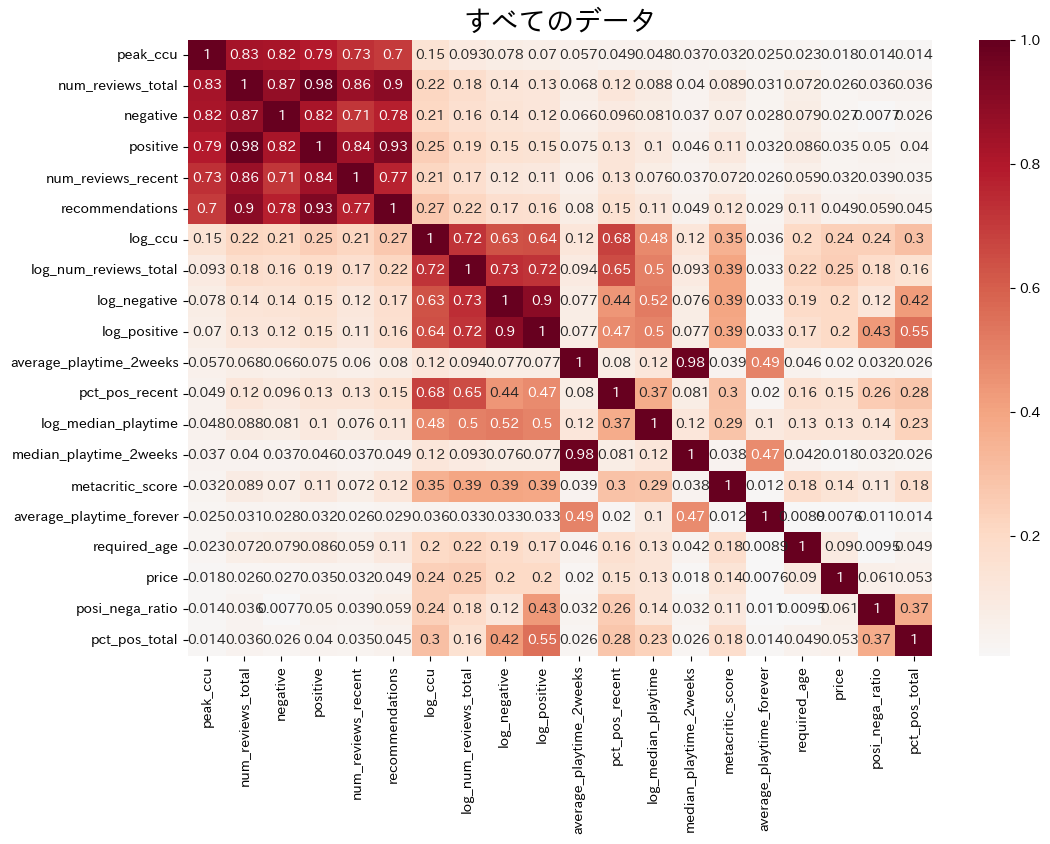

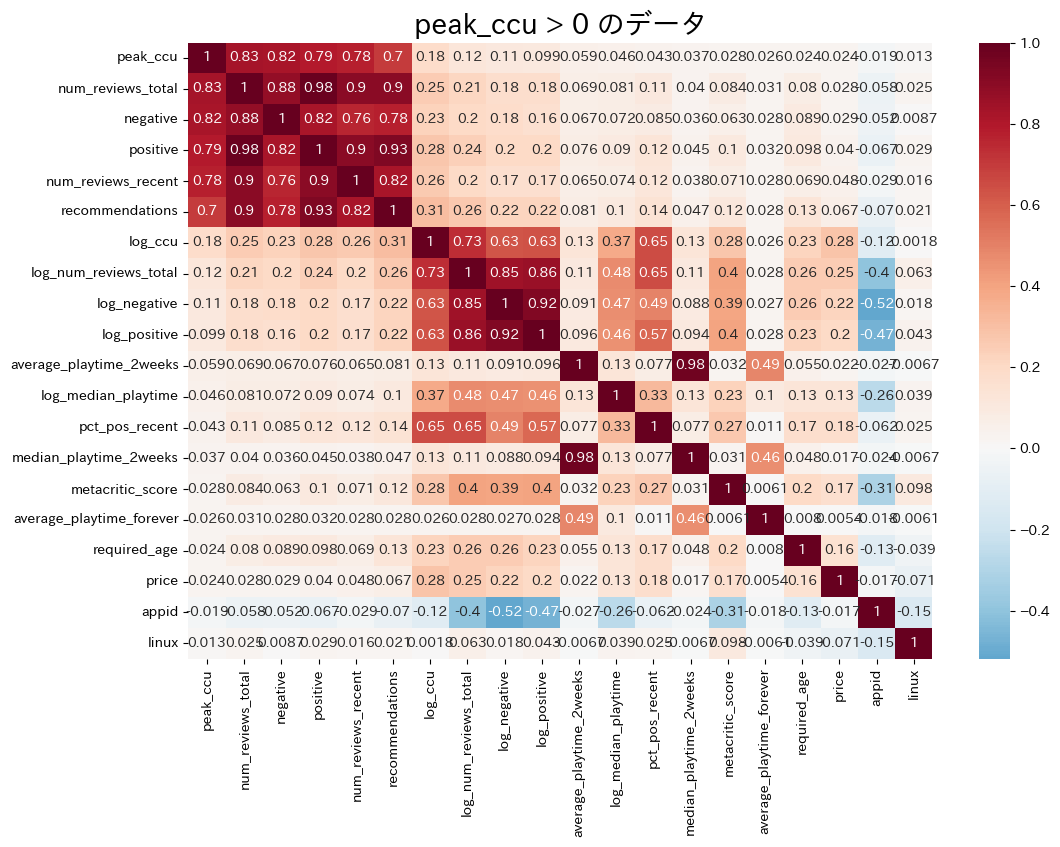

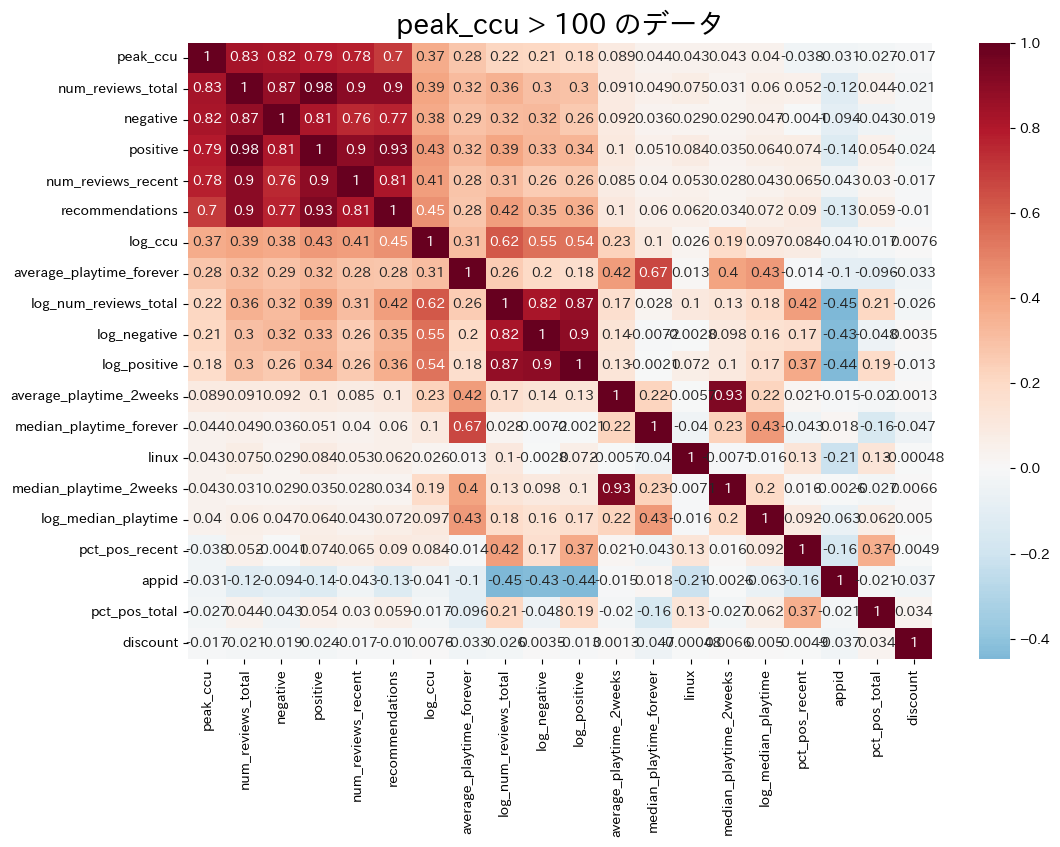

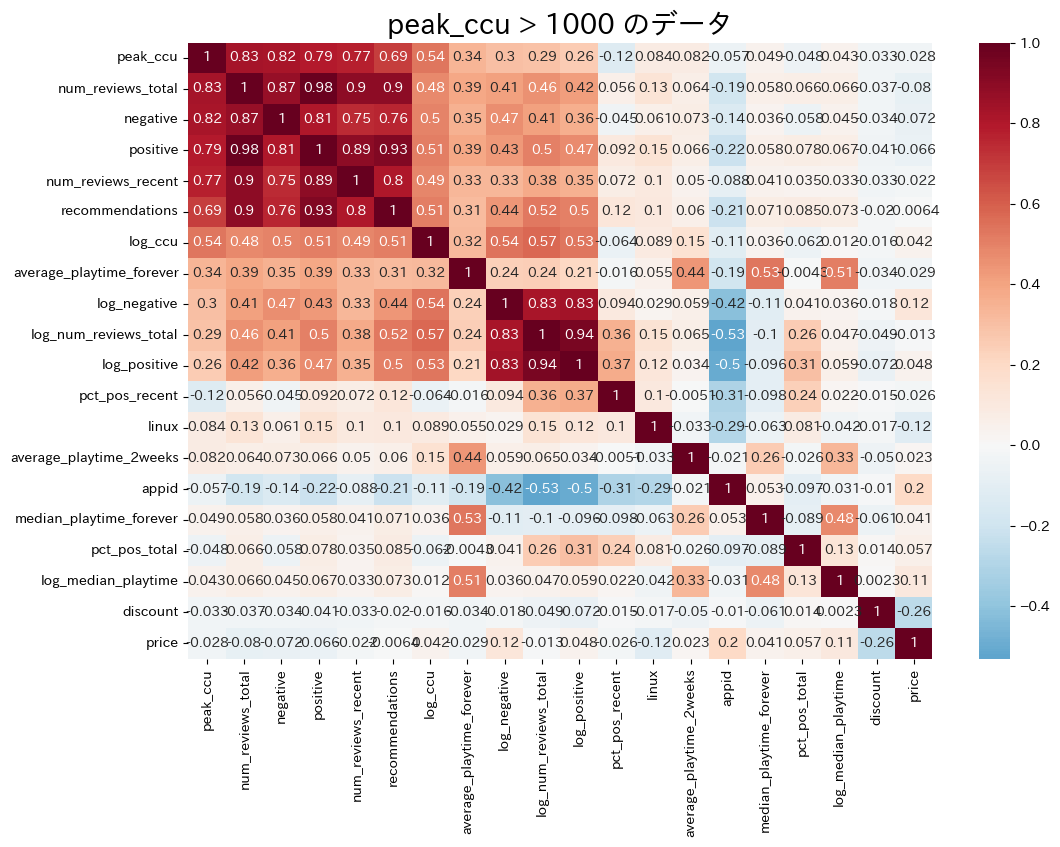

In [37]:
top_corr_cols = df.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('すべてのデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_active.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_active[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('peak_ccu > 0 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_100.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_100[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('peak_ccu > 100 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_1000.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_1000[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('peak_ccu > 1000 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

In [10]:
zero_count = (df['peak_ccu'] == 0).sum()
print(f"同時接続ゼロのゲーム数: {zero_count} / 全体: {len(df)}")

print(f"log_ccu の最大値: {df['log_ccu'].max()}")

同時接続ゼロのゲーム数: 70698 / 全体: 89618
log_ccu の最大値: 14.008076956694195


In [68]:
all_models = []
formula = "peak_ccu ~ positive"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               peak_ccu   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     3441.
Date:                Thu, 19 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:51:41   Log-Likelihood:                -23403.
No. Observations:                2042   AIC:                         4.681e+04
Df Residuals:                    2040   BIC:                         4.682e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2385.6276    520.877     -4.580      0.0

In [69]:
formula = "log_ccu ~ log_positive"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     835.3
Date:                Thu, 19 Feb 2026   Prob (F-statistic):          3.03e-154
Time:                        19:51:41   Log-Likelihood:                -3331.8
No. Observations:                2042   AIC:                             6668.
Df Residuals:                    2040   BIC:                             6679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.9505      0.119     24.759   

In [70]:
formula = "log_ccu ~ log_negative"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     890.0
Date:                Thu, 19 Feb 2026   Prob (F-statistic):          1.34e-162
Time:                        19:51:42   Log-Likelihood:                -3312.6
No. Observations:                2042   AIC:                             6629.
Df Residuals:                    2040   BIC:                             6640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.4064      0.101     33.795   

In [71]:
formula = "log_ccu ~ log_positive + log_negative"
mod = smf.ols(formula, data = df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     467.1
Date:                Thu, 19 Feb 2026   Prob (F-statistic):          9.84e-168
Time:                        19:51:42   Log-Likelihood:                -3297.1
No. Observations:                2042   AIC:                             6600.
Df Residuals:                    2039   BIC:                             6617.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0586      0.118     25.943   

In [72]:
print(f"現在 {len(all_models)} 個のモデルが溜まっています")
st = Stargazer(all_models)
st.custom_columns([f"Model {i+1}" for i in range(len(all_models))], [1]*len(all_models))
st

現在 4 個のモデルが溜まっています


In [95]:
df_100 = df_100.dropna(subset=['publishers'])
# 1. シンプルにユニークな名前の数を見る
print(f"ユニークなパブリッシャー数: {df_100['publishers'].nunique()}")

# 2. 出版数ランキング（被り＝同じパブリッシャーが複数のゲームを出しているか）
publisher_counts = df_100['publishers'].value_counts()
print(publisher_counts.head(20)) # 上位20社を表示

# 3. 1つしかゲームを出していないパブリッシャーがどれくらいいるか
single_game_pubs = (publisher_counts == 1).sum()
print(f"1作品しか出していないパブリッシャー数: {single_game_pubs}")

ユニークなパブリッシャー数: 1147
publishers
['Electronic Arts']               50
['Ubisoft']                       47
['SEGA']                          46
['Square Enix']                   34
['KOEI TECMO GAMES CO., LTD.']    28
['Xbox Game Studios']             27
['Bethesda Softworks']            25
['THQ Nordic']                    25
['CAPCOM Co., Ltd.']              23
['Activision']                    20
['Focus Entertainment']           18
['Paradox Interactive']           17
['2K']                            17
['Nacon']                         16
['PlayStation Publishing LLC']    16
['Deep Silver']                   14
['Bandai Namco Entertainment']    14
['Team17']                        13
['Rockstar Games']                11
['Devolver Digital']              10
Name: count, dtype: int64
1作品しか出していないパブリッシャー数: 927


In [96]:
# 1. 検定用データの作成（CCU100以上のデータを使用）
# 必要な変数に欠損値がある行をあらかじめ削除
df_hm = df_100.dropna(subset=['pub_id', 'log_ccu', 'log_positive', 'log_negative', 'price']).copy()

# パブリッシャーIDを「個体」、appidを「時間/観測単位」としてインデックス設定
# これにより linearmodels がパネル構造を認識する
df_hm = df_hm.set_index(['pub_id', 'appid'])

# 2. 固定効果モデル (Fixed Effects)
# EntityEffects=True がパブリッシャー固定効果を意味する
mod_fe = PanelOLS.from_formula("log_ccu ~ log_positive + log_negative + price + EntityEffects", data=df_hm)
res_fe = mod_fe.fit()

# 3. ランダム効果モデル (Random Effects)
mod_re = RandomEffects.from_formula("log_ccu ~ log_positive + log_negative + price", data=df_hm)
res_re = mod_re.fit()

# 4. ハウスマン検定関数の実行
def perform_hausman(fe, re):
    b_fe = fe.params
    b_re = re.params
    v_fe = fe.cov
    v_re = re.cov
    
    # 定数項以外で共通する係数を抽出
    common_idx = [i for i in b_fe.index if i in b_re.index]
    
    b_diff = np.atleast_2d(b_fe[common_idx] - b_re[common_idx])
    cov_diff = v_fe.loc[common_idx, common_idx] - v_re.loc[common_idx, common_idx]
    
    stat = abs(np.dot(np.dot(b_diff, np.linalg.inv(cov_diff)), b_diff.T).item())
    df = len(common_idx)
    p_val = 1 - chi2.cdf(stat, df)
    
    print("--- Hausman Test Results ---")
    print(f"Chi-squared statistic: {stat:.4f}")
    print(f"Degrees of freedom: {df}")
    print(f"p-value: {p_val:.4f}")
    
    if p_val < 0.05:
        print("結論: p < 0.05 なのでランダム効果モデルを棄却。固定効果モデル(FE)を採用すべきです。")
    else:
        print("結論: p >= 0.05 なのでランダム効果モデル(RE)を排除できません。")

perform_hausman(res_fe, res_re)

--- Hausman Test Results ---
Chi-squared statistic: 27.3482
Degrees of freedom: 3
p-value: 0.0000
結論: p < 0.05 なのでランダム効果モデルを棄却。固定効果モデル(FE)を採用すべきです。


In [ ]:
model_fe = smf.ols("log_ccu ~ log_positive + price + C(pub_id) + C(main_genre)", data=df_100).fit()

In [87]:
print(model_fe.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     2.144
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           7.18e-32
Time:                        18:53:12   Log-Likelihood:                -2296.5
No. Observations:                2042   AIC:                             6937.
Df Residuals:                     870   BIC:                         1.353e+04
Df Model:                        1171                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [85]:
Stargazer.omit_covariates(['pub_id', 'main_genre'])

AttributeError: type object 'Stargazer' has no attribute 'omit_covariates'

In [74]:
formula = "peak_ccu ~ positive + discount + price"
mod = smf.ols(formula, data=df)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               peak_ccu   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                 5.030e+04
Date:                Thu, 19 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:19:34   Log-Likelihood:            -8.5823e+05
No. Observations:               89618   AIC:                         1.716e+06
Df Residuals:                   89614   BIC:                         1.717e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -47.0574     13.774     -3.416      0.0

「無理に埋めて『綺麗な嘘』をつくより、『大手タイトルほどPlaytimeが欠損しやすい傾向があるため、本分析では欠損フラグを導入して対応した』と書くほうが、論文としての格が上がりますよ。」
まずは、その「ヤバい欠損」がどの程度の割合で、どの層（CCU上位など）に発生しているか、df.isnull().sum()とあわせて確認してみませんか？

positiveとかNegativeとかをXにしてCCUに対して個別プロットして、PDDの点を探したらいい？

差分OLSをいっぱい回してStargazerで確認

固定効果モデルの推定:
smf.ols("log_ccu ~ log_pos + price + C(publisher_id)", data=df) のように、カテゴリ変数をぶち込んでみましょう。

ハウスマン検定 (Hausman Test):
「固定効果モデル」と「ランダム効果モデル」を比較して、「会社ごとの個性（固有効果）が、説明変数と相関しちゃってるか？」を判定します。これで星の意味がまた変わります。

RDD (断絶割当デザイン) への挑戦:
例えば「Steamのセール（割引率 0% vs 1%）」や「ランキングの掲載順位」など、ある閾値で何かが劇的に変わるポイントがあれば、そこを境界にして因果推論を試せます。